In [1]:
!pip install pyspark

# Nouvelle section

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
import re
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [3]:
# Initialize a Spark session
spark = SparkSession.builder.appName("TwitterSentimentAnalysis").master('local[*]').getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/16 15:39:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("branch", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("tweet", StringType(), True)
])

training = spark.read.csv("twitter_training.csv", header=True, schema=schema)
validation = spark.read.csv("twitter_validation.csv", header=True, schema=schema)


In [5]:
training.printSchema()
validation.printSchema()

root
 |-- id: integer (nullable = true)
 |-- branch: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- tweet: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- branch: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- tweet: string (nullable = true)


In [6]:
training.show()

24/05/16 15:39:54 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: tweet_id, topic, sentiment, tweet
 Schema: id, branch, sentiment, tweet
Expected: id but found: tweet_id
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_training.csv


+----+-----------+---------+--------------------+
|  id|     branch|sentiment|               tweet|
+----+-----------+---------+--------------------+
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|I am coming to th...|
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|im coming on bord...|
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|im getting into b...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|So I spent a coup...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|2010 So I spent a...|
|2402|Borderlands| Positive|                 was|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Vita...|
|2403|Borderlands|  Neutral|Live Rock - Hard ...|


In [7]:
validation.show()

24/05/16 15:40:01 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/05/16 15:40:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: tweet_id, topic, sentiment, tweet
 Schema: id, branch, sentiment, tweet
Expected: id but found: tweet_id
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_validation.csv


+-----+--------------------+----------+--------------------+
|   id|              branch| sentiment|               tweet|
+-----+--------------------+----------+--------------------+
| 3364|            Facebook|Irrelevant|I mentioned on Fa...|
|  352|              Amazon|   Neutral|BBC News - Amazon...|
| 8312|           Microsoft|  Negative|@Microsoft Why do...|
| 4371|               CS-GO|  Negative|CSGO matchmaking ...|
| 4433|              Google|   Neutral|Now the President...|
| 6273|                FIFA|  Negative|Hi @EAHelp I’ve h...|
| 7925|           MaddenNFL|  Positive|Thank you @EAMadd...|
| NULL|                NULL|      NULL|                NULL|
| NULL|                NULL|      NULL|                NULL|
| NULL|                NULL|      NULL|                NULL|
|11332|TomClancysRainbowSix|  Positive|Rocket League, Se...|
| 1107|      AssassinsCreed|  Positive|my ass still knee...|
| 2069|          CallOfDuty|  Negative|FIX IT JESUS ! Pl...|
| 3185|               Do

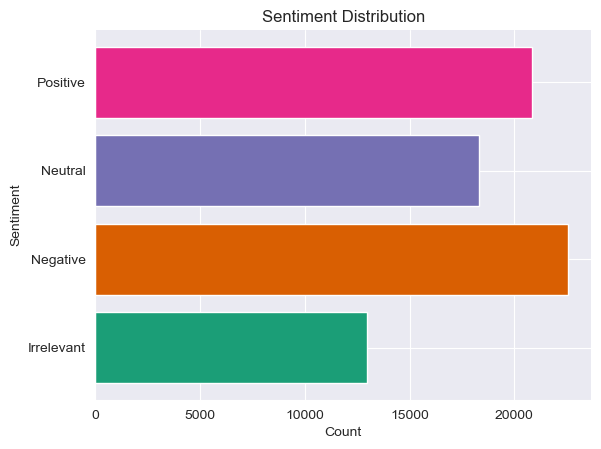

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by sentiment and count the occurrences
sentiment_counts = training.groupBy('sentiment').count().orderBy('sentiment')

# Collect data to the driver
sentiment_counts_collect = sentiment_counts.collect()

# Extract sentiment labels and counts
sentiments = [row['sentiment'] for row in sentiment_counts_collect]
counts = [row['count'] for row in sentiment_counts_collect]

# Plotting
plt.barh(sentiments, counts, color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution')
plt.show()


In [9]:
from pyspark.sql.functions import sum, col

# Count null values in each column
missing_values1 = training.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in training.columns])

# Show the result
missing_values1.show()


24/05/16 15:40:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: tweet_id, topic, sentiment, tweet
 Schema: id, branch, sentiment, tweet
Expected: id but found: tweet_id
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_training.csv


+---+------+---------+-----+
| id|branch|sentiment|tweet|
+---+------+---------+-----+
|  0|     0|        0|  686|
+---+------+---------+-----+


In [10]:
# Drop rows with any null values
training = training.na.drop()

# Show the updated DataFrame
training.show()


+----+-----------+---------+--------------------+
|  id|     branch|sentiment|               tweet|
+----+-----------+---------+--------------------+
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|I am coming to th...|
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|im coming on bord...|
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|im getting into b...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|So I spent a coup...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|2010 So I spent a...|
|2402|Borderlands| Positive|                 was|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Vita...|
|2403|Borderlands|  Neutral|Live Rock - Hard ...|


24/05/16 15:40:23 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: tweet_id, topic, sentiment, tweet
 Schema: id, branch, sentiment, tweet
Expected: id but found: tweet_id
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_training.csv


24/05/16 15:40:25 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: tweet_id, topic, sentiment, tweet
 Schema: id, branch, sentiment, tweet
Expected: id but found: tweet_id
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_training.csv


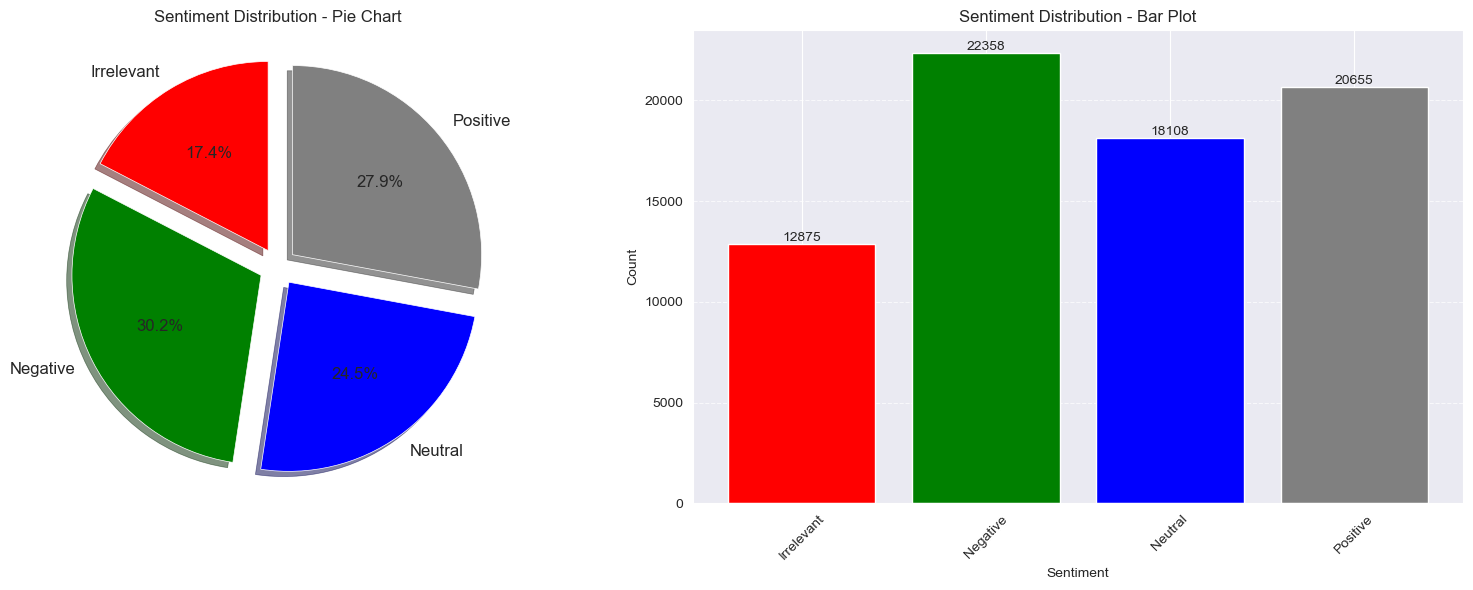

In [11]:
import matplotlib.pyplot as plt

# Calculate sentiment distribution
sentiment_distribution = training.groupBy('sentiment').count().orderBy('sentiment').toPandas()

# Define colors
colors = ['red', 'green', 'blue', 'gray']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting pie chart for sentiment distribution with custom colors
axs[0].pie(sentiment_distribution['count'], labels=sentiment_distribution['sentiment'], autopct='%1.1f%%',
            startangle=90, wedgeprops={'linewidth': 0.5}, textprops={'fontsize': 12},
            explode=[0.1, 0.1, 0.1, 0.1], colors=colors, shadow=True)
axs[0].set_title('Sentiment Distribution - Pie Chart')

# Plotting bar plot for sentiment distribution
axs[1].bar(sentiment_distribution['sentiment'], sentiment_distribution['count'], color=colors)
axs[1].set_title('Sentiment Distribution - Bar Plot')
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
# Add text on top of each bar in the bar plot
for i, count in enumerate(sentiment_distribution['count']):
    axs[1].text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [12]:
# Filter out rows with non-string values in the specified column
def filter_non_string(df, column):
    df = df.filter(df[column].isNotNull())
    df = df.withColumn(column, df[column].cast(StringType()))
    return df

In [13]:
# Convert text to lowercase
def normalize_text(text):
    return text.lower()

In [14]:
# Remove HTML tags from the text
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

In [15]:
# Remove URLs or hyperlinks from the text
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

In [16]:
# Exclude numerical digits from the text
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

In [17]:
# Remove punctuation marks from the text
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

In [18]:
# Remove emojis from the text
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [19]:
from pyspark.ml.feature import RegexTokenizer

def tokenize_text(dataframe, input_col, output_col):
    """Tokenize the text column in the given DataFrame."""
    tokenizer = RegexTokenizer(inputCol=input_col, outputCol=output_col, pattern="\\W")
    return tokenizer.transform(dataframe)

In [20]:
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

def remove_stopwords(tokens):
    """Eliminate common stopwords from the tokenized text using PySpark."""
    remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
    return remover.transform(tokens).select("filtered_tokens")

In [21]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType

def vectorize_data(text_data):
    """Vectorize the tokenized text data using TF-IDF in PySpark."""
    # Join the tokenized text into strings
    text_data_strings = [" ".join(tokens) for tokens in text_data]

    # Create DataFrame from text data
    text_df = spark.createDataFrame(zip(range(len(text_data_strings)), text_data_strings), ["id", "text"])

    # Tokenize text
    tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
    tokenized_df = tokenizer.transform(text_df)

    # Count Vectorizer
    cv = CountVectorizer(inputCol="tokens", outputCol="raw_features")
    cv_model = cv.fit(tokenized_df)
    count_vectorized_df = cv_model.transform(tokenized_df)

    # Compute IDF
    idf = IDF(inputCol="raw_features", outputCol="features")
    idf_model = idf.fit(count_vectorized_df)
    tfidf_vectorized_df = idf_model.transform(count_vectorized_df)

    # Select only the features column
    select_features_udf = udf(lambda features: features.toArray().tolist(), ArrayType())
    return tfidf_vectorized_df.select("id", select_features_udf("features")).withColumnRenamed("<lambda>(features)", "tfidf_vectors"), cv_model


In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer

def preprocess_text(df):
    # Filter non-string values in the 'tweet' column
    df = filter_non_string(df, 'tweet')
    # Define UDFs for text preprocessing steps
    normalize_text_udf = udf(normalize_text, StringType())
    remove_html_tags_udf = udf(remove_html_tags, StringType())
    remove_urls_udf = udf(remove_urls, StringType())
    remove_numbers_udf = udf(remove_numbers, StringType())
    remove_punctuation_udf = udf(remove_punctuation, StringType())
    remove_emojis_udf = udf(remove_emojis, StringType())

    # Apply text preprocessing steps using DataFrame transformations
    df = df.withColumn("tweet", normalize_text_udf("tweet"))
    df = df.withColumn("tweet", remove_html_tags_udf("tweet"))
    df = df.withColumn("tweet", remove_urls_udf("tweet"))
    df = df.withColumn("tweet", remove_numbers_udf("tweet"))
    df = df.withColumn("tweet", remove_punctuation_udf("tweet"))

    # Tokenize text
    tokenizer = Tokenizer(inputCol="tweet", outputCol="tokens")
    df = tokenizer.transform(df)

    # Remove stopwords
    remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
    df = remover.transform(df).select("branch","tweet",'sentiment', "filtered_tokens")


    return df

# Assuming 'training' is your Spark DataFrame
df_processed = preprocess_text(training)
test_validation=preprocess_text(validation)


24/05/16 15:40:32 WARN StopWordsRemover: Default locale set was [en_MA]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
24/05/16 15:40:33 WARN StopWordsRemover: Default locale set was [en_MA]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [23]:
df_processed.show()

24/05/16 15:40:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: tweet_id, topic, sentiment, tweet
 Schema: id, branch, sentiment, tweet
Expected: id but found: tweet_id
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_training.csv


+-----------+--------------------+---------+--------------------+
|     branch|               tweet|sentiment|     filtered_tokens|
+-----------+--------------------+---------+--------------------+
|Borderlands|im getting on bor...| Positive|[im, getting, bor...|
|Borderlands|i am coming to th...| Positive|[coming, borders,...|
|Borderlands|im getting on bor...| Positive|[im, getting, bor...|
|Borderlands|im coming on bord...| Positive|[im, coming, bord...|
|Borderlands|im getting on bor...| Positive|[im, getting, bor...|
|Borderlands|im getting into b...| Positive|[im, getting, bor...|
|Borderlands|so i spent a few ...| Positive|[spent, hours, ma...|
|Borderlands|so i spent a coup...| Positive|[spent, couple, h...|
|Borderlands|so i spent a few ...| Positive|[spent, hours, so...|
|Borderlands|so i spent a few ...| Positive|[spent, hours, ma...|
|Borderlands| so i spent a few...| Positive|[, spent, hours, ...|
|Borderlands|                 was| Positive|                  []|
|Borderlan

In [24]:
test_validation.show()

+--------------------+--------------------+----------+--------------------+
|              branch|               tweet| sentiment|     filtered_tokens|
+--------------------+--------------------+----------+--------------------+
|            Facebook|i mentioned on fa...|Irrelevant|[mentioned, faceb...|
|              Amazon|bbc news  amazon ...|   Neutral|[bbc, news, , ama...|
|           Microsoft|microsoft why do ...|  Negative|[microsoft, pay, ...|
|               CS-GO|csgo matchmaking ...|  Negative|[csgo, matchmakin...|
|              Google|now the president...|   Neutral|[president, slapp...|
|                FIFA|hi eahelp ive had...|  Negative|[hi, eahelp, ive,...|
|           MaddenNFL|thank you eamadde...|  Positive|[thank, eamaddennfl]|
|TomClancysRainbowSix|rocket league sea...|  Positive|[rocket, league, ...|
|      AssassinsCreed|my ass still knee...|  Positive|[ass, still, knee...|
|          CallOfDuty|fix it jesus  ple...|  Negative|[fix, jesus, , pl...|
|           

24/05/16 15:40:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: topic, sentiment, tweet
 Schema: branch, sentiment, tweet
Expected: branch but found: topic
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_validation.csv


In [25]:
from pyspark.sql.functions import concat_ws

# Convert list of words into a single string for each entry in 'tweet' column
df_processed = df_processed.withColumn("tweet", concat_ws(" ", "filtered_tokens"))

# Show the updated DataFrame
df_processed.show()

24/05/16 15:40:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: tweet_id, topic, sentiment, tweet
 Schema: id, branch, sentiment, tweet
Expected: id but found: tweet_id
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_training.csv


+-----------+--------------------+---------+--------------------+
|     branch|               tweet|sentiment|     filtered_tokens|
+-----------+--------------------+---------+--------------------+
|Borderlands|im getting border...| Positive|[im, getting, bor...|
|Borderlands| coming borders kill| Positive|[coming, borders,...|
|Borderlands|im getting border...| Positive|[im, getting, bor...|
|Borderlands|im coming borderl...| Positive|[im, coming, bord...|
|Borderlands|im getting border...| Positive|[im, getting, bor...|
|Borderlands|im getting border...| Positive|[im, getting, bor...|
|Borderlands|spent hours makin...| Positive|[spent, hours, ma...|
|Borderlands|spent couple hour...| Positive|[spent, couple, h...|
|Borderlands|spent hours somet...| Positive|[spent, hours, so...|
|Borderlands|spent hours makin...| Positive|[spent, hours, ma...|
|Borderlands| spent hours maki...| Positive|[, spent, hours, ...|
|Borderlands|                    | Positive|                  []|
|Borderlan

In [26]:
from pyspark.sql.functions import concat_ws

# Convert list of words into a single string for each entry in 'tweet' column
test_validation = test_validation.withColumn("tweet", concat_ws(" ", "filtered_tokens"))

# Show the updated DataFrame
test_validation.show()

24/05/16 15:40:48 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: topic, sentiment, tweet
 Schema: branch, sentiment, tweet
Expected: branch but found: topic
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_validation.csv


+--------------------+--------------------+----------+--------------------+
|              branch|               tweet| sentiment|     filtered_tokens|
+--------------------+--------------------+----------+--------------------+
|            Facebook|mentioned faceboo...|Irrelevant|[mentioned, faceb...|
|              Amazon|bbc news  amazon ...|   Neutral|[bbc, news, , ama...|
|           Microsoft|microsoft pay wor...|  Negative|[microsoft, pay, ...|
|               CS-GO|csgo matchmaking ...|  Negative|[csgo, matchmakin...|
|              Google|president slappin...|   Neutral|[president, slapp...|
|                FIFA|hi eahelp ive mad...|  Negative|[hi, eahelp, ive,...|
|           MaddenNFL|   thank eamaddennfl|  Positive|[thank, eamaddennfl]|
|TomClancysRainbowSix|rocket league sea...|  Positive|[rocket, league, ...|
|      AssassinsCreed|ass still kneedee...|  Positive|[ass, still, knee...|
|          CallOfDuty|fix jesus  please...|  Negative|[fix, jesus, , pl...|
|           

In [27]:
df_processed.show()


24/05/16 15:40:49 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: tweet_id, topic, sentiment, tweet
 Schema: id, branch, sentiment, tweet
Expected: id but found: tweet_id
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_training.csv


+-----------+--------------------+---------+--------------------+
|     branch|               tweet|sentiment|     filtered_tokens|
+-----------+--------------------+---------+--------------------+
|Borderlands|im getting border...| Positive|[im, getting, bor...|
|Borderlands| coming borders kill| Positive|[coming, borders,...|
|Borderlands|im getting border...| Positive|[im, getting, bor...|
|Borderlands|im coming borderl...| Positive|[im, coming, bord...|
|Borderlands|im getting border...| Positive|[im, getting, bor...|
|Borderlands|im getting border...| Positive|[im, getting, bor...|
|Borderlands|spent hours makin...| Positive|[spent, hours, ma...|
|Borderlands|spent couple hour...| Positive|[spent, couple, h...|
|Borderlands|spent hours somet...| Positive|[spent, hours, so...|
|Borderlands|spent hours makin...| Positive|[spent, hours, ma...|
|Borderlands| spent hours maki...| Positive|[, spent, hours, ...|
|Borderlands|                    | Positive|                  []|
|Borderlan

In [28]:
from pyspark.ml.feature import HashingTF, CountVectorizer
from pyspark.ml.classification import LogisticRegression , LogisticRegressionModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Split data into training and testing sets
train_df, test_df = df_processed.randomSplit([0.8, 0.2], seed=42)

# Assuming 'sentiment' column is your label column
indexer = StringIndexer(inputCol="sentiment", outputCol="label")

# Using CountVectorizer
cv = CountVectorizer(inputCol="filtered_tokens", outputCol="features", vocabSize=50000)

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=1000, regParam=0.01)

pipeline = Pipeline(stages=[cv,indexer])

pipeline_fit = pipeline.fit(train_df)
train_df=pipeline_fit.transform(train_df)


model = lr.fit(train_df)
test_df = pipeline_fit.transform(test_df)
predictions = model.transform(test_df)
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)


24/05/16 15:40:52 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: tweet_id, topic, sentiment, tweet
 Schema: id, branch, sentiment, tweet
Expected: id but found: tweet_id
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_training.csv
24/05/16 15:41:03 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: tweet_id, topic, sentiment, tweet
 Schema: id, branch, sentiment, tweet
Expected: id but found: tweet_id
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_training.csv
24/05/16 15:41:10 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: tweet_id, topic, sentiment, tweet
 Schema: id, branch, sentiment, tweet
Expected: id but found: tweet_id
CSV file: file:///Users/marouandgh/IdeaProjects/Twitter_sentiment/Model/twitter_training.csv
24/05/16 15:41:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/16 15:41:17 WA

Test Accuracy: 0.8487394957983193


In [29]:
# Save the model
model.write().overwrite().save("LrModel")
pipeline_fit.write().overwrite().save('Pipline')


24/05/16 15:51:07 WARN TaskSetManager: Stage 114 contains a task of very large size (1108 KiB). The maximum recommended task size is 1000 KiB.


In [30]:
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
pipline_path = "Pipline"
pipeline = PipelineModel.load(pipline_path)
lr_model = LogisticRegressionModel.load('LrModel')
df_chil3iba_chil3iba = pipeline.transform(test_validation)
predictionston = lr_model.transform(df_chil3iba_chil3iba)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictionston)
print("Validation Accuracy:", accuracy)


24/05/16 15:51:22 WARN DAGScheduler: Broadcasting large task binary with size 1586.6 KiB


Validation Accuracy: 0.895
